In [1]:
import tensorflow as tf
import math
import pandas as pd
import numpy as np
from random import shuffle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [2]:
predict_graph_def = tf.compat.v1.GraphDef()
predict_model_path = '../models/224-tml-testing/'
if os.path.exists(predict_model_path):
    print(f"Loading model from {predict_model_path}")
    predict_file = tf.io.gfile.GFile(predict_model_path + "predict_graph.pb", 'rb')
    predict_graph_def.ParseFromString(predict_file.read())
    predict_graph = tf.import_graph_def(predict_graph_def, name='predict')
    predict_sess = tf.compat.v1.Session(graph=predict_graph)
    predict_logits = predict_sess.graph.get_tensor_by_name(f"predict/conv2d_5/Sigmoid:0") 
    #predict_logits = predict_sess.graph.get_tensor_by_name(f"predict/clip_by_value:0") 
    #feature_extraction = predict_sess.graph.get_tensor_by_name(f"predict/csse_out_mul/mul:0")  
    #feature_extraction_initial = predict_sess.graph.get_tensor_by_name(
    #    "predict/conv_median_drop/drop_block2d_1/cond/Merge:0")
    predict_inp = predict_sess.graph.get_tensor_by_name("predict/Placeholder:0")
    predict_length = predict_sess.graph.get_tensor_by_name("predict/PlaceholderWithDefault:0")
else:
    raise Exception(f"The model path {predict_model_path} does not exist")


Loading model from ../models/224-tml-testing/


In [3]:
def predict_subtile(subtile: np.ndarray, sess: "tf.Sess", op: "tf.Tensor", size: "int") -> np.ndarray:
    if np.sum(subtile) != 0:
        if not isinstance(subtile.flat[0], np.floating):
            print("CONVERTING TO FLOAT")
            assert np.max(subtile) > 1
            subtile = subtile / 65535.
        #subtile[..., 10] = 0.
        for band in range(0, subtile.shape[-1]):
            mins = min_all[band]
            maxs = max_all[band]
            #if band == 10:
            subtile[..., band] = np.clip(subtile[..., band], mins, maxs)
            midrange = (maxs + mins) / 2
            rng = maxs - mins
            standardized = (subtile[..., band] - midrange) / (rng / 2)
            subtile[..., band] = standardized
        batch_x = subtile[np.newaxis, :, 1:-1, 1:-1].astype(np.float32)
        
        lengths = np.full((batch_x.shape[0]), 4)
        preds = sess.run(op,
                              feed_dict={predict_inp:batch_x, 
                                         predict_length:lengths})
        preds = preds.squeeze()
        
        clip = (preds.shape[0] - size) // 2
        #preds = preds[1:-1, 1:-1]
        if clip > 0:
            preds = preds[clip:-clip, clip:-clip]
        #preds = np.clip(preds, 0, 1)
        preds = np.float32(preds)

    else:
        preds = np.full((SIZE, SIZE), 255)
        print(f"The sum of the subtile is {np.sum(subtile)}")
    
    return preds

min_all = [0.006576638437476157, 0.0162050812542916, 0.010040436408026246, 
               0.013351644159609368, 0.01965362020294499, 0.014229037918669413, 
               0.015289539940489814, 0.011993591210803388, 0.008239871824216068,
               0.006546120393682765, 0.0, 0.0, 0.0, -0.1409399364817101,
               -0.4973397113668104, -0.09731556326714398, -0.7193834232943873]

max_all = [0.2691233691920348, 0.3740291447318227, 0.5171435111009385, 
               0.6027466239414053, 0.5650263218127718, 0.5747005416952773,
               0.5933928435187305, 0.6034943160143434, 0.7472037842374304,
               0.7000076295109483, 
               0.4,
               #0.509269855802243, 
               0.948334642387533, 
               0.6729257769285485, 0.8177635298774327, 0.35768999002433816,
               0.7545951919107605, 0.7602693339366691]
#min_all = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0.2, -0.6, -0.2, -0.8]
#max_all = [0.6, 0.6, 0.6, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.5, 1., 0.8, 1., 0.5, 1., 1.]
#max_all[10] = 0.509

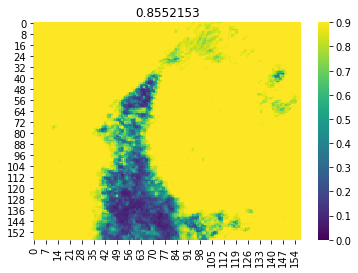

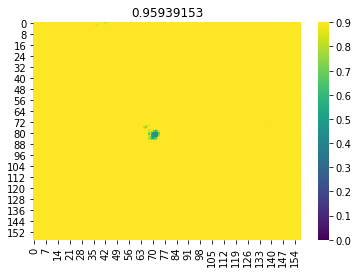

In [4]:
x = np.load("../src/input_12.npy")
y1 = predict_subtile(np.pad(x, ((0, 0), (1, 1), (1, 1), (0, 0))), predict_sess, predict_logits, 160)
#y[y < 0.3] = 0.
sns.heatmap(y1, cmap = 'viridis', vmax = 0.9, vmin = 0)
plt.title(np.mean(y1))
plt.show()

x = np.load("../src/input_2.npy")
x[..., 10] *= 1.5
y1 = predict_subtile(np.pad(x, ((0, 0), (1, 1), (1, 1), (0, 0))), predict_sess, predict_logits, 160)
#y[y < 0.3] = 0.
sns.heatmap(y1, cmap = 'viridis', vmax = 0.9, vmin = 0)
plt.title(np.mean(y1))
plt.show()

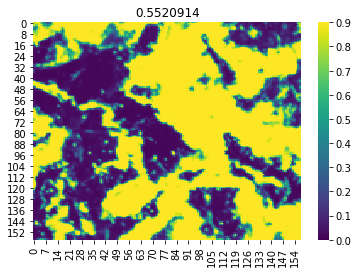

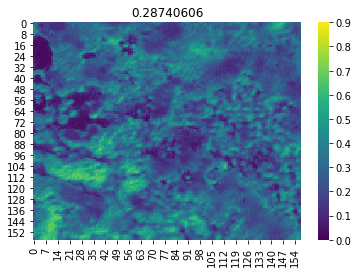

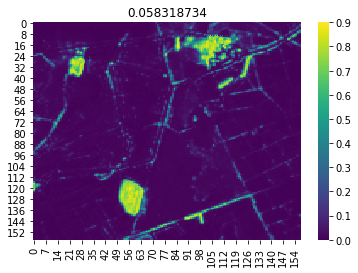

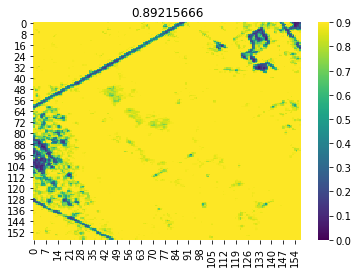

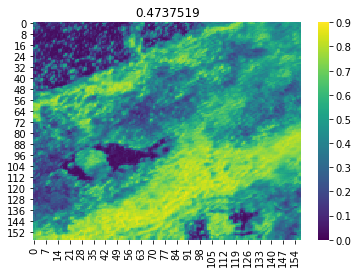

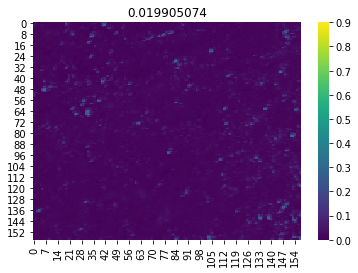

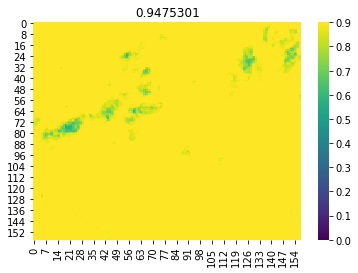

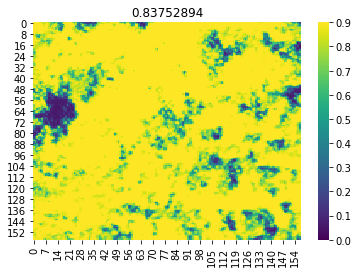

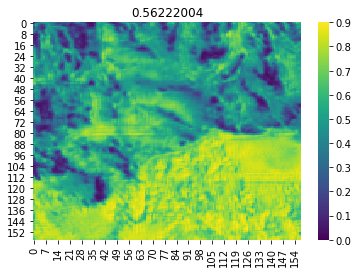

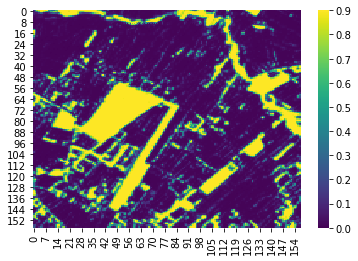

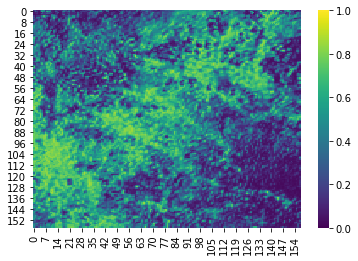

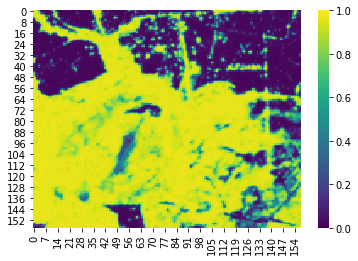

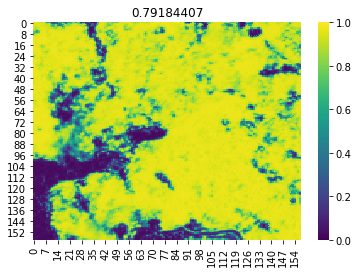

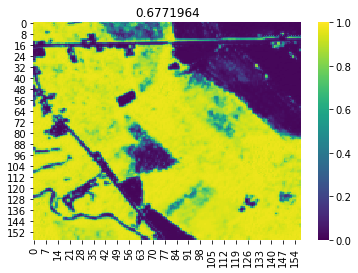

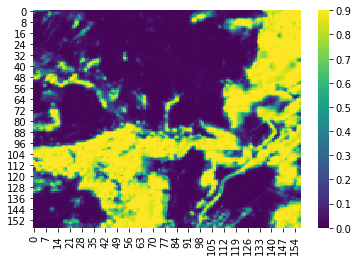

In [5]:

x = np.load("../src/subtile_0_cr.npy")
y = predict_subtile(x, predict_sess, predict_logits, 160)
sns.heatmap(y, cmap = 'viridis', vmax = 0.9, vmin = 0)
plt.title(np.mean(y))
plt.show()

x = np.load("../src/subtile_80.npy")
y = predict_subtile(x, predict_sess, predict_logits, 160)
sns.heatmap(y, cmap = 'viridis', vmax = 0.9, vmin = 0)
plt.title(np.mean(y))
plt.show()


x = np.load("../src/brazil_0.npy")
y = predict_subtile(x, predict_sess, predict_logits, 160)
sns.heatmap(y, cmap = 'viridis', vmax = 0.9, vmin = 0)
plt.title(np.mean(y))
plt.show()

x = np.load("../src/subtile_12.npy")
y = predict_subtile(x, predict_sess, predict_logits, 160)
sns.heatmap(y, cmap = 'viridis', vmax = 0.9, vmin = 0)
plt.title(np.mean(y))
plt.show()

x = np.load("../src/subtile_6.npy")
y = predict_subtile(x, predict_sess, predict_logits, 160)
sns.heatmap(y, cmap = 'viridis', vmax = 0.9, vmin = 0)
plt.title(np.mean(y))
plt.show()

x = np.load("../src/subtile_29.npy")
y = predict_subtile(x, predict_sess, predict_logits, 160)
sns.heatmap(y, cmap = 'viridis', vmax = 0.9, vmin = 0)
plt.title(np.mean(y))
plt.show()

x = np.load("../src/subtile_39_cr.npy")
y = predict_subtile(x, predict_sess, predict_logits, 160)
sns.heatmap(y, cmap = 'viridis', vmax = 0.9, vmin = 0)
plt.title(np.mean(y))
plt.show()

x = np.load("../src/subtile_40.npy")
y = predict_subtile(x, predict_sess, predict_logits, 160)
sns.heatmap(y, cmap = 'viridis', vmax = 0.9, vmin = 0)
plt.title(np.mean(y))
plt.show()

x = np.load("../src/subtile_47.npy")
y = predict_subtile(x, predict_sess, predict_logits, 160)
sns.heatmap(y, cmap = 'viridis', vmax = 0.9, vmin = 0)
plt.title(np.mean(y))
plt.show()

x = np.load("../src/subtile_48.npy")
y = predict_subtile(x, predict_sess, predict_logits, 160)
sns.heatmap(y, cmap = 'viridis', vmax = 0.9, vmin = 0)
plt.show()



x = np.load("../src/subtile_64.npy")
y = predict_subtile(x, predict_sess, predict_logits, 160)
sns.heatmap(y, cmap = 'viridis', vmax = 1, vmin = 0)
plt.show()

x = np.load("../src/subtile_72.npy")
y = predict_subtile(x, predict_sess, predict_logits, 160)
sns.heatmap(y, cmap = 'viridis', vmax = 1, vmin = 0)
plt.show()

x = np.load("../src/subtile_72_ghana.npy")
y = predict_subtile(x, predict_sess, predict_logits, 160)
sns.heatmap(y, cmap = 'viridis', vmax = 1, vmin = 0)
plt.title(np.mean(y))
plt.show()

x = np.load("../src/subtile_71_2.npy")
y = predict_subtile(x, predict_sess, predict_logits, 160)
sns.heatmap(y, cmap = 'viridis', vmax = 1, vmin = 0)
plt.title(np.mean(y))
plt.show()

x = np.load("../src/subtile_79.npy")
y = predict_subtile(x, predict_sess, predict_logits, 160)
#y[y < 0.3] = 0.
sns.heatmap(y, cmap = 'viridis', vmax = 0.9, vmin = 0)
plt.show()



In [6]:

yout = np.full((160, 272, 5), np.nan)
yout[:,:160:, 0] = y1
yout[:,28:160+28, 1] = y2
yout[:,28+28:160+28+28, 2] = y3
yout[:,28+28+28:160+28+28+28, 3] = y4
yout[:,28+28+28+28:160+28+28+28+28, 4] = y5
yout2 = np.nanmean(yout, axis = -1)
yout3 = np.nanmax(yout, axis = -1) - np.nanmin(yout, axis = -1)


ValueError: could not broadcast input array from shape (158,158) into shape (160,160)

In [ ]:
plt.figure(figsize=(9,4))
sns.heatmap(yout2, cmap = 'viridis')

### 